---
---

# Data Assimilation and Tempering: (Very) Simple Experiments



In [2]:
"""
Based in code from Juan Jose Ruiz
"""
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

import numpy as np
from scipy.linalg import sqrtm
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

plt.rcParams.update({'font.size': 15})
np.random.seed(70)

ens_size = 5000                      # Size of the ensemble for PF
kalman_ens_size = 20                 # Size of the ensemble for the ensemble Kalman filter update
x_mean   = 5.0                       # Mean of the original state variable.
x_std    = 2.5                       # Standard deviation of the state variable.
dbz_tr   = 0.0                       # Minimum dBZ value.
qr_model_bias = 0.0e-4               # When generating the true qr we can add a model bias.
R=np.power( 5.0 , 2 )                # Observation error for reflectivity
Ntemp=3                              # Number of tempered steps
def get_temp_steps( Ntemp , Alpha_s ) :

   #NTemp is the number of tempering steps to be performed.
   #Alpha is a slope coefficient. Larger alpha means only a small part of the information
   #will be assimilated in the first step (and the largest part will be assimilated in the last step).

   steps = np.exp( (Ntemp+1)* Alpha_s / np.arange( 1,Ntemp+1 ) )
   steps = steps / np.sum(steps)

   return steps

alpha = get_temp_steps( Ntemp , 2.0 )
alpha_inverse = (alpha ) * np.sum( 1/alpha )
print(f'Alpha coeficients: {alpha}')
print(f'Sum alpha coeficients: {sum(alpha)}')

def calc_ref_bis( x , dbz_tr=0,c = 1221.2518127994958) :
   """
   observation operator that relates the state variable (x) with a radar reflectivity output, also a lower treshold (dbz_tr) is define to correct the transformations
   """

   if x < 5.0 :
      ref = 0.0
   else       :
      ref = 10.0 * np.log10( c * ( x-5.0)**1.75 + 1.0 )

   if ref < dbz_tr:
      ref = dbz_tr

   return ref

def inv_calc_ref_bis(ref, dbz_tr=0, c=1221.2518127994958):
    """
    Inverse of the calc_ref_bis function.
    Given reflectivity (dBZ), return the corresponding state variable x.
    Assumes x >= 5.0.
    """
    # Apply threshold
    ref = max(ref, dbz_tr)
    
    if ref <= 0:
        return 0.0  # For reflectivities that correspond to x < 5.0
    else:
        x = 5 + ((10**(ref / 10) - 1) / c) ** (1 / 1.75)
        return x


def calc_etkf_filter_update( dbz_ens , qr_ens , dbz_obs , R_dbz ) :

    qr_ens_mean = np.mean( qr_ens )
    qr_ens_pert = qr_ens - qr_ens_mean

    y_ens = np.zeros( qr_ens.size )
    for ii in range( qr_ens.size ) :
        y_ens[ii] = calc_ref_bis( qr_ens[ii] )
    y_mean = np.mean( y_ens )
    y_pert = y_ens - y_mean

    dy = dbz_obs - calc_ref_bis( qr_ens_mean )
    Rinv = 1/R_dbz

    Pahat =np.linalg.inv(   np.outer( y_pert.T , Rinv*y_pert ) + ( qr_ens.size -1)*np.identity(qr_ens.size) )

    wabar = np.dot( Pahat , y_pert * Rinv * dy )
    Wa = np.real( sqrtm( (qr_ens.size-1)*Pahat) )

    qr_a_ens_mean = qr_ens_mean + np.dot( qr_ens_pert , wabar )
    qr_a_ens_pert = np.dot( qr_ens_pert , Wa )
    qr_a_ens = qr_a_ens_mean + qr_a_ens_pert
    dbz_a_ens = np.zeros( qr_a_ens.shape )

    qr_a_ens[qr_a_ens < 0.0]=0.0
    for ii in range( qr_ens.size ) :
        dbz_a_ens[ii] = calc_ref_bis( qr_a_ens[ii] )


    return dbz_a_ens , qr_a_ens

x_ens = x_mean+x_std*np.random.randn( ens_size )                         #Define x ensemble with random noise standad noise
x_true = x_mean + 0.8                                                    #Define the true state variable base in the mean of the ensamble size and an arbitrary number

dbz_true = calc_ref_bis( x_true )
dbz_obs = dbz_true + (R**0.5) * np.random.randn( 1 )
x_obs = inv_calc_ref_bis( dbz_obs )
if dbz_obs < dbz_tr :
    dbz_obs = dbz_tr

#First compute the ensemble in terms of graupel concentration.
dbz_ens = np.zeros( np.shape( x_ens ) )

for i in range( ens_size ):
    dbz_ens[i] = calc_ref_bis( x_ens[i] )

dbz_a_ens = np.copy( dbz_ens[0:kalman_ens_size])
x_a_ens = np.copy( x_ens[0:kalman_ens_size])

dbz_a_ens_temp = np.copy( dbz_ens[0:kalman_ens_size])  #define the transformed array for the tempered data
x_a_ens_temp  = np.copy( x_ens[0:kalman_ens_size])     #define the state variable array for the tempered data


x_ens_temp_evol = np.zeros( ( kalman_ens_size , len(alpha)+1 ) )
x_ens_evol = np.zeros( ( kalman_ens_size , 2 ) )
x_ens_temp_evol[:,0] = x_ens[0:kalman_ens_size]
x_ens_evol[:,0] = x_ens[0:kalman_ens_size]

dbz_ens_temp_evol = np.zeros( ( kalman_ens_size , len(alpha)+1 ) )
dbz_ens_evol = np.zeros( ( kalman_ens_size , 2 ) )
dbz_ens_temp_evol[:,0] = dbz_ens[0:kalman_ens_size]
dbz_ens_evol[:,0] = dbz_ens[0:kalman_ens_size]

#first we calculate the normal ETKF process
dbz_a_ens , x_a_ens = calc_etkf_filter_update( dbz_a_ens , x_a_ens , dbz_obs , R )
x_ens_evol[:,1] = x_a_ens
dbz_ens_evol[:,1] = dbz_a_ens
#then we stimate the tempered ETKF process with 3 iteratios, note tha here the difference is in the R, that is muliplied by the alpha
for it in range( alpha.size ) :
    dbz_a_ens_temp , x_a_ens_temp = calc_etkf_filter_update( dbz_a_ens_temp , x_a_ens_temp , dbz_obs , R * alpha_inverse[it] )
    x_ens_temp_evol[:,it+1] = np.copy( x_a_ens_temp )
    dbz_ens_temp_evol[:,it+1] = np.copy( dbz_a_ens_temp )

#Then we use a very simple and basic particle filter

pf_w = np.exp(-( dbz_ens - dbz_obs )**2/R  )
pf_w = pf_w / np.sum( pf_w)



Alpha coeficients: [0.97737992 0.01790134 0.00471874]
Sum alpha coeficients: 1.0


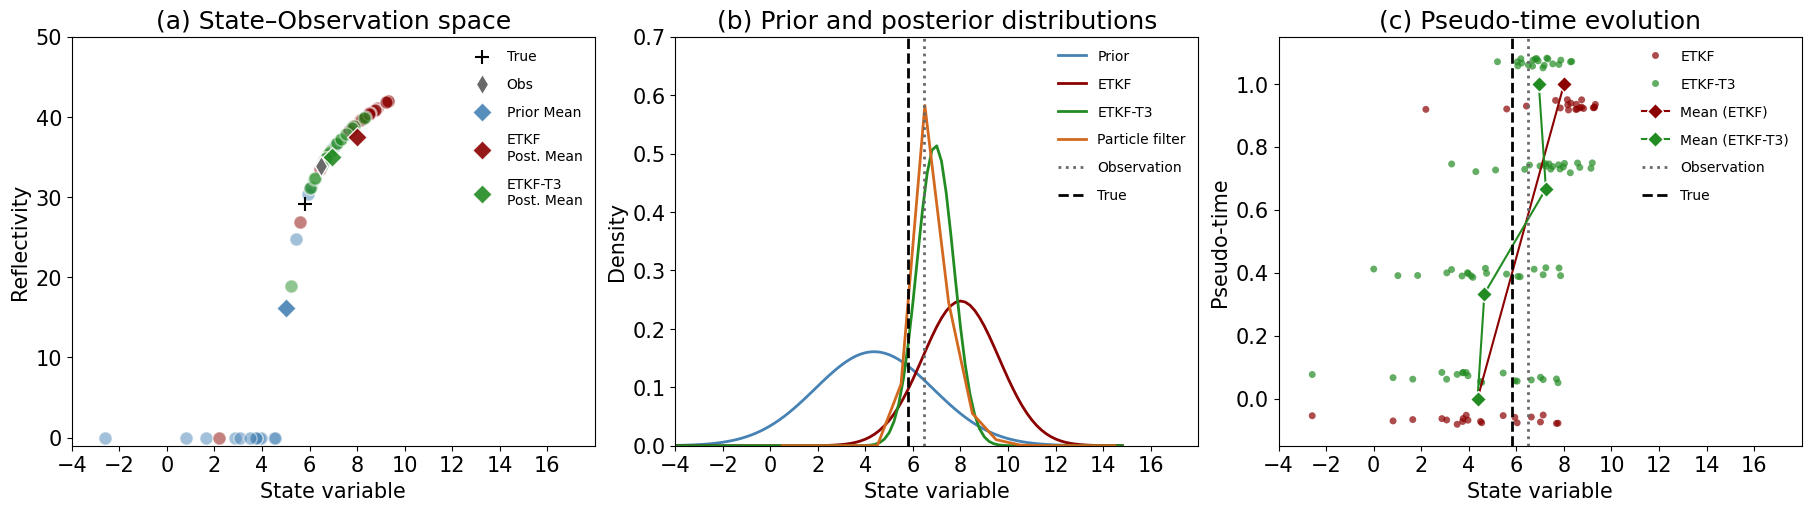

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Reusing existing arrays from original logic (simulated here for demonstration)
np.random.seed(70)
kalman_ens_size = 20
Ntemp = 3
step_labels = ['Prior', 'Step 1', 'Step 2', 'Step 3']



# Plot the full 3-panel figure
fig, axs = plt.subplots(1, 3, figsize=(18, 5), constrained_layout=True)

####################################################################################################
# Panel (a) - stylized schematic
####################################################################################################

axs[0].scatter( x_ens[0:kalman_ens_size]   , dbz_ens[0:kalman_ens_size],c = 'SteelBlue',  marker = 'o', s=90.0, edgecolor = 'w', zorder=10,alpha=0.5)
axs[0].scatter( x_a_ens, dbz_a_ens ,c = 'DarkRed',    marker = 'o', s=90.0, edgecolor = 'w', zorder=10,alpha=0.5)
axs[0].scatter( x_a_ens_temp , dbz_a_ens_temp ,c = 'ForestGreen',marker = 'o', s=90.0, edgecolor = 'w', zorder=10,alpha=0.5)
axs[0].scatter( x_true, dbz_true, marker='+', c='Black',  s=110.0, label='True', zorder=100, edgecolor = 'w')
axs[0].scatter( x_obs, dbz_obs,  marker='d', c='DimGray', s=110.0, label='Obs', zorder=100, edgecolor = 'w')

axs[0].scatter(np.mean( x_ens       ),np.mean(dbz_ens       ),c = 'SteelBlue',  marker = 'D', s=100.0, edgecolor = 'w',label='Prior Mean', zorder=10,alpha=0.9)
axs[0].scatter(np.mean( x_a_ens     ),np.mean(dbz_a_ens     ),c = 'DarkRed',    marker = 'D', s=100.0, edgecolor = 'w',label='ETKF\nPost. Mean', zorder=10,alpha=0.9)
axs[0].scatter(np.mean( x_a_ens_temp),np.mean(dbz_a_ens_temp),c = 'ForestGreen',marker = 'D', s=100.0, edgecolor = 'w',label='ETKF-T3\nPost. Mean', zorder=10,alpha=0.9)

axs[0].set_xlabel('State variable')
axs[0].set_ylabel('Reflectivity')
axs[0].legend(loc='upper right', fontsize=10, frameon=False, labelspacing = 1)
axs[0].set_title('(a) State–Observation space')
axs[0].set_ylim(-1, 50)
axs[0].set_xlim(-4, 18)
axs[0].set_xticks(np.arange(-4, 17, 2))
####################################################################################################
# Panel (b) - PDFs
####################################################################################################

xf_mean = np.mean( x_ens[0:kalman_ens_size] )
xf_std  = np.std( x_ens[0:kalman_ens_size] )
x_vals = np.arange(-4,15,0.2)
pdf_prior= (1.0/(xf_std*np.sqrt(np.pi*2)))*np.exp(-0.5*(x_vals-xf_mean)**2/xf_std**2)

xa_mean = np.mean( x_a_ens )
xa_std  = np.std( x_a_ens )
pdf_etkf= (1.0/(xa_std*np.sqrt(np.pi*2)))*np.exp(-0.5*(x_vals-xa_mean)**2/xa_std**2)

xat_mean = np.mean( x_a_ens_temp )
xat_std  = np.std( x_a_ens_temp )
pdf_etkf_t3= (1.0/(xat_std*np.sqrt(np.pi*2)))*np.exp(-0.5*(x_vals-xat_mean)**2/xat_std**2)

xapf_hist , xapf_bins = np.histogram( x_ens , weights=pf_w , bins=np.arange(0.0,16.0,1))
xapf_bins_plot= 0.5 * ( xapf_bins[0:-1] + xapf_bins[1:] )

axs[1].plot(x_vals, pdf_prior, color='SteelBlue', label='Prior', linewidth=2)
axs[1].plot(x_vals, pdf_etkf, color='DarkRed', label='ETKF', linewidth=2)
axs[1].plot(x_vals, pdf_etkf_t3, color='ForestGreen', label='ETKF-T3', linewidth=2)
axs[1].plot(xapf_bins_plot , xapf_hist/np.sum(xapf_hist) , 'Chocolate', label='Particle filter', linewidth=2)
axs[1].axvline(x_obs, color='DimGray', linestyle=':', linewidth=2, label='Observation')
axs[1].axvline(x_true, color='Black', linestyle='--', linewidth=2, label='True')
axs[1].set_xlabel('State variable')
axs[1].set_ylabel('Density')
axs[1].set_title('(b) Prior and posterior distributions')
axs[1].legend(loc='upper right', fontsize=10, frameon=False, labelspacing = 1)
axs[1].set_xlim(-4, 18)
axs[1].set_xticks(np.arange(-4, 17, 2))
axs[1].set_ylim(0, 0.7)
####################################################################################################
# --- Panel (c): Mean ± Std ---
####################################################################################################
# Prepare ETKF-T3 points
etkf_t3_data = {
    'Step': np.repeat(np.arange(Ntemp + 1)/Ntemp, kalman_ens_size),
    'State': x_ens_temp_evol.flatten('F'),
    'Method': ['ETKF-T3'] * (kalman_ens_size * (Ntemp + 1))
}

# Prepare ETKF points
etkf_data = {
    'Step': np.repeat([0, 1], kalman_ens_size),
    'State': x_ens_evol.flatten('F'),
    'Method': ['ETKF'] * (kalman_ens_size * 2)
}

# Combine
df_scatter = pd.DataFrame.from_dict({
    'Step': np.concatenate([etkf_data['Step'],etkf_t3_data['Step']]),
    'State': np.concatenate([etkf_data['State'],etkf_t3_data['State']]),
    'Method': np.concatenate([etkf_data['Method'],etkf_t3_data['Method']])
})

sns.stripplot(data=df_scatter, x='State', y='Step', hue='Method', jitter=True,native_scale=True,
              dodge=True, palette={'ETKF': 'DarkRed', 'ETKF-T3': 'ForestGreen'}, ax=axs[2], alpha=0.7,orient='y',zorder=0)

# Optional: Add mean points
etkf_means = np.mean(x_ens_evol, axis=0)
axs[2].plot(etkf_means,[0, 1], '-', marker='D', markersize=8, markeredgecolor = 'w', color='DarkRed', label='Mean (ETKF)',zorder=5)

etkf_t3_means = np.mean(x_ens_temp_evol, axis=0)
axs[2].plot(etkf_t3_means,np.arange(Ntemp + 1)/Ntemp, '-', marker='D', markersize=8, markeredgecolor = 'w', color='ForestGreen', label='Mean (ETKF-T3)',zorder=5)



# Observation line
axs[2].axvline(x_obs, color='DimGray', linestyle=':', linewidth=2, label='Observation',zorder=10)
axs[2].axvline(x_true, color='Black', linestyle='--', linewidth=2, label='True',zorder=10)
# Final touches
axs[2].set_title('(c) Pseudo-time evolution')
axs[2].set_xlabel('State variable')
axs[2].set_ylabel('Pseudo-time')
axs[2].legend(loc='upper right', fontsize=10, frameon=False, labelspacing = 1)
axs[2].set_xlim(-4, 18)
axs[2].set_ylim(-0.15, 1.15)
axs[2].set_xticks(np.arange(-4, 17, 2))
#plt.show()

plt.savefig("Figure0DTempering_final_jitter.png", dpi=300, bbox_inches='tight')
plt.savefig("Figure0DTempering_final_jitter.pdf", bbox_inches='tight')